# Import statements

In [1]:
import pop_tools
import xarray as xr
import numpy as np
import cftime
import xesmf as xe
import cmocean
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
from scipy.signal import coherence, csd
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.stats import linregress
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker
import scipy.signal as signal
from scipy import stats
from sklearn.linear_model import LinearRegression
import xgcm
import warnings
warnings.filterwarnings('ignore')  # Add this at the top of your script

In [2]:
import processing_utils as proc_utils
import cesm2_lens_utils
import analysis_funcs as afuncs

### Functions

In [3]:
def regridded_var(dsxgcm, gridxgcm, var,target_range, val):
    regridded = gridxgcm.transform(
        dsxgcm[var] - val,
        axis="Z",
        target=target_range,
        target_data=dsxgcm[var],
        method="linear",
    )

    regridded.coords["z_t"] = gridxgcm.transform(
        dsxgcm.z_t.broadcast_like(dsxgcm[var]),
        axis="Z",
        target=target_range,
        target_data=dsxgcm[var],
        method="linear",
    )
    return regridded

In [4]:
def grid_info(variables_xr, ds_g_new):
    # GRID
    DZT = np.zeros((33,231,153))

    for k in range(33):
        DZT[k,:,:] = variables_xr.z_t[k]

    ds2 = xr.Dataset({
        'DZT': (['z_t','nlat','nlon',], DZT),
        'DZU': (['z_t','nlat','nlon'], DZT)},
                     coords={'TLAT': (['nlat','nlon'],variables_xr.TLAT.data),
                             'TLONG': (['nlat','nlon'],variables_xr.TLONG.data),
                             'ULAT': (['nlat','nlon'],variables_xr.ULAT.data),
                             'ULONG': (['nlat','nlon'],variables_xr.ULONG.data),
                             'z_t': (['z_t'],variables_xr.z_t.data)})
    
    variables_xr = variables_xr.assign_coords(z_w=ds_g_new.z_w[:33])
    variables_xr = variables_xr.assign_coords(z_w_bot=ds_g_new.z_w_bot[:33])

    variables_xr["DXU"] = ds_g_new.DXU
    variables_xr["DYU"] = ds_g_new.DYU
    variables_xr["DXT"] = ds_g_new.DXT
    variables_xr["DYT"] = ds_g_new.DYT
    variables_xr["UAREA"] = ds_g_new.UAREA
    variables_xr["TAREA"] = ds_g_new.TAREA
    variables_xr["DZT"] = ds2.DZT
    variables_xr["DZU"] = ds2.DZU
    variables_xr["dz"] = variables_xr.z_t

    variables_xr.DZT.attrs["long_name"] = "Thickness of T cells"
    variables_xr.DZT.attrs["units"] = "centimeter"
    variables_xr.DZT.attrs["grid_loc"] = "3111"
    variables_xr.DZU.attrs["long_name"] = "Thickness of U cells"
    variables_xr.DZU.attrs["units"] = "centimeter"
    variables_xr.DZU.attrs["grid_loc"] = "3221"

    metrics = {
        ("X",): ["DXU", "DXT"],  # X distances
        ("Y",): ["DYU", "DYT"],  # Y distances
        ("Z",): ["DZU", "DZT"],  # Z distances
        ("X", "Y"): ["UAREA", "TAREA"],
    }

    gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
        variables_xr,
        periodic=False,
        metrics=metrics,
        boundary={"X": "extend", "Y": "extend", "Z": "extend"},
    )

    return gridxgcm, dsxgcm

# Double-ITCZ Index

In [159]:
DII = xr.open_dataset('DII_all_ens.nc').PRECT

In [174]:
print(DII.mean(dim='time').argmax())

<xarray.DataArray 'PRECT' ()> Size: 8B
array(98)


In [164]:
print(DII.mean(dim='time').argsort())

<xarray.DataArray 'PRECT' (ensemble_member: 100)> Size: 800B
array([81,  9, 36,  2, 60, 32, 34, 66, 93, 90, 44, 88, 30, 47, 48, 42, 11,
       18, 24, 65, 84, 91, 19, 61,  8, 72, 74,  5, 52,  4, 82, 62, 73, 69,
       14, 41, 58, 49, 67, 78, 56, 25, 51,  7, 59, 38, 26, 29, 92, 99, 70,
       54, 68, 22, 15, 37, 77, 27, 86, 10, 87, 16, 13, 31, 20, 33, 43, 83,
       50, 95, 94,  3, 17, 75,  1, 85,  0, 45, 97, 79, 57, 71, 12, 89, 76,
       46, 23, 28, 39,  6, 96, 63, 21, 35, 53, 40, 64, 80, 55, 98])
Coordinates:
  * ensemble_member  (ensemble_member) int64 800B 0 1 2 3 4 5 ... 95 96 97 98 99

# Load data

In [5]:
# filepath_g = pop_tools.DATASETS.fetch('cesm_pop_monthly.T62_g17.nc')
# xr_terms = xr.open_dataset(filepath_g).isel(nlon=slice(140, 293), nlat=slice(72, 303), z_t = slice(0, 33))

filepath_g = pop_tools.DATASETS.fetch('daily_surface_potential_temperature.nc')
ds_g_new = xr.open_dataset(filepath_g).isel(nlon=slice(140, 293), nlat=slice(72, 303))

# LENS

In [6]:
ENS_MEMB = 0
[0, 65,  32, 85, 61, 90, 80, 68, 73, 49] 

In [9]:
for ENS_MEMB in [49]:#[65,  32, 85, 61, 90, 80, 68, 73, 49]:
    # print(ENS_MEMB)
    # LENS_PD = afuncs.ocn_var_ens(ENS_MEMB, 'PD').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()
    # LENS_TEMP = afuncs.ocn_var_ens(ENS_MEMB, 'TEMP').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()
    # # LENS_SALT = afuncs.ocn_var_ens(ENS_MEMB, 'SALT').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()
    
    # variables_xr = xr.Dataset()
    # variables_xr['PD'] = LENS_PD*1000 - 1000
    # variables_xr['TEMP'] = LENS_TEMP
    # # variables_xr['SALT'] = LENS_SALT
    
    gridxgcm, dsxgcm = grid_info(variables_xr, ds_g_new)
    
    regridded_PD = regridded_var('PD',np.arange(24, 25.4, 0.2), 0)
    regridded_TEMP = regridded_var('TEMP',np.arange(19., 21., 0.5), 273.15)
    
    # dsxgcm["rho"] = pop_tools.eos(dsxgcm.SALT, dsxgcm.TEMP, depth=dsxgcm.z_t * 1e-2)
    # regridded_rho = regridded_var('rho',np.arange(23.5, 26.5, 0.5), 1000)
    
    TEMP_zt = dsxgcm.TEMP.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})
    
    regridded = gridxgcm.transform(
            dsxgcm.PD - 0,
            axis="Z",
            target=np.arange(19,21,0.5),
            target_data=TEMP_zt,
            method="linear",)
    
    regridded.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_PD_{}.nc'.format(ENS_MEMB))
    regridded_TEMP.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_TEMP_{}.nc'.format(ENS_MEMB))

In [ ]:
%%time
ENS_MEMB = 65

LENS_PD = afuncs.ocn_var_ens(ENS_MEMB, 'PD').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()
LENS_TEMP = afuncs.ocn_var_ens(ENS_MEMB, 'TEMP').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()
# LENS_SALT = afuncs.ocn_var_ens(ENS_MEMB, 'SALT').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()

variables_xr = xr.Dataset()
variables_xr['PD'] = LENS_PD*1000 - 1000
variables_xr['TEMP'] = LENS_TEMP
# variables_xr['SALT'] = LENS_SALT

gridxgcm, dsxgcm = grid_info(variables_xr, ds_g_new)

regridded_PD = regridded_var('PD',np.arange(24, 25.4, 0.2), 0)
regridded_TEMP = regridded_var('TEMP',np.arange(19., 21., 0.5), 273.15)

# dsxgcm["rho"] = pop_tools.eos(dsxgcm.SALT, dsxgcm.TEMP, depth=dsxgcm.z_t * 1e-2)
# regridded_rho = regridded_var('rho',np.arange(23.5, 26.5, 0.5), 1000)

TEMP_zt = dsxgcm.TEMP.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})

regridded = gridxgcm.transform(
        dsxgcm.PD - 0,
        axis="Z",
        target=np.arange(19,21,0.5),
        target_data=TEMP_zt,
        method="linear",)

regridded.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_PD_{}.nc'.format(ENS_MEMB))
regridded_TEMP.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_TEMP_{}.nc'.format(ENS_MEMB))

In [33]:
# LENS_TEMP = afuncs.ocn_var_ens(ENS_MEMB, 'TEMP').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()
# LENS_PV = afuncs.ocn_var_ens(ENS_MEMB, 'PV').isel(z_t=slice(0, 33))[:,:, 72:303,140:293].compute()

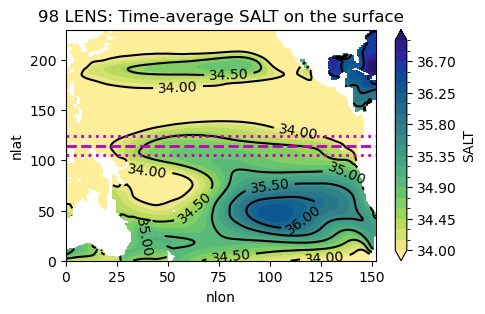

In [62]:
plt.figure(figsize=(5, 3))
cf = (LENS_SALT.isel(z_t = 0).mean(dim='time')).plot.contourf(vmin=34, vmax=37, levels=21, cmap=cmocean.cm.haline_r)
contour_obj = (LENS_SALT.isel(z_t = 0).mean(dim='time')).plot.contour(levels=np.arange(34, 37, 0.5), cmap='k')
# (LENS_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[24.4, 24.8], cmap='hotpink')

plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.title('98 LENS: Time-average SALT on the surface')
plt.show()

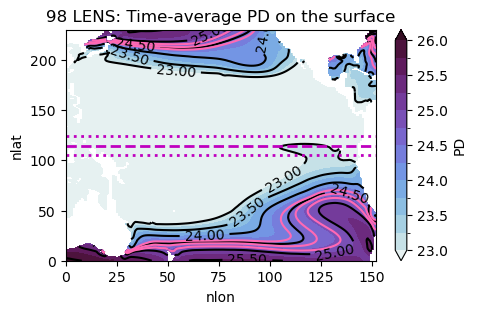

In [8]:
plt.figure(figsize=(5, 3))
cf = (LENS_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contourf(vmin=23, vmax=26, levels=13, cmap=cmocean.cm.dense)
contour_obj = (LENS_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[23, 23.5, 24, 24.5, 25, 25.5, 26], cmap='k')
(LENS_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[24.4, 24.6, 24.8], cmap='hotpink')

plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.title('98 LENS: Time-average PD on the surface')
plt.show()

In [34]:
# variables_xr = xr.Dataset()
# # variables_xr['PD'] = LENS_PD*1000 - 1000
# variables_xr['TEMP'] = LENS_TEMP
# # variables_xr['SALT'] = LENS_SALT
# variables_xr['PV'] = LENS_PV

In [38]:
# TEMP_zt = dsxgcm.TEMP.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})

# PV_zt = dsxgcm.PV.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})
# regridded_PV = gridxgcm.transform(
#         PV_zt - 0,
#         axis="Z",
#         target=np.arange(19,21,0.5),
#         target_data=TEMP_zt,
#         method="linear",)

# regridded_PV.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_PV_0.nc')

In [ ]:
##### mask = xr.where(regridded.isel(TEMP = 2).mean(dim='time') > 25.55, np.nan, regridded.isel(TEMP = 2).mean(dim='time'))
mask_binarize = xr.where(mask > 0., 1., np.nan)

regridded_no_Atlantic = regridded*mask_binarize

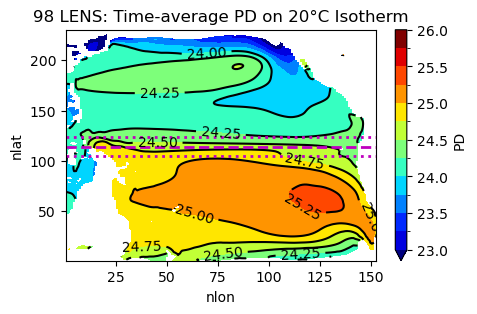

In [51]:
plt.figure(figsize=(5, 3))
cf = regridded_no_Atlantic.isel(TEMP = 2).mean(dim='time')[:,:].plot.contourf(vmin=23.0, vmax=26.0, levels=13, cmap='jet')
contour_obj = regridded_no_Atlantic.isel(TEMP = 2).mean(dim='time')[:,:].plot.contour(levels=[24.0, 24.25, 24.5, 24.75, 25., 25.25, 25.50], colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.title('98 LENS: Time-average PD on 20°C Isotherm')
plt.show()

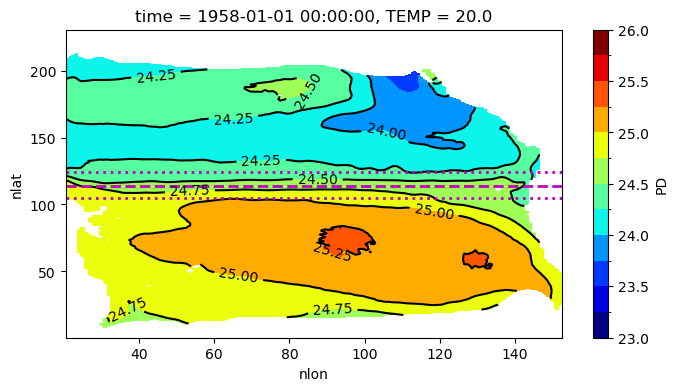

In [14]:
tstep = 0

plt.figure(figsize=(8, 4))
cf = regridded_no_Atlantic.isel(TEMP = 2)[tstep,:,20:].plot.contourf(vmin=23, vmax=26, levels=13, cmap='jet')
contour_obj = regridded_no_Atlantic.isel(TEMP = 2)[tstep,:,20:].plot.contour(levels=[24.0, 24.25, 24.5, 24.75, 25., 25.25, 25.50], colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.show()

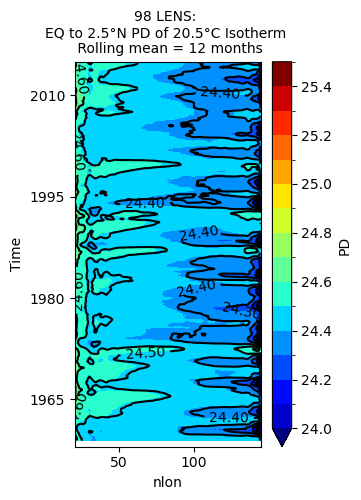

In [23]:
plt.figure(figsize=(3, 5))
cf = regridded.isel(TEMP = 2)[:,115:124,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contourf(cmap='jet', vmin=24., vmax=25.5, levels=16)
contour_obj = regridded.isel(TEMP = 2)[:,114:124,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contour(levels=np.arange(24., 25.5, 0.1), colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f', colors='k')
plt.title('98 LENS: \nEQ to 2.5°N PD of 20°C Isotherm \n Rolling mean = 12 months', fontsize=10)
plt.ylabel('Time', fontsize=10)
plt.show()

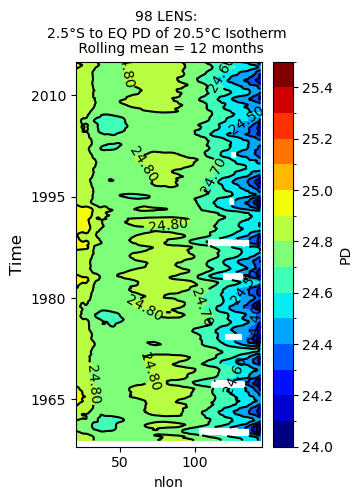

In [24]:
plt.figure(figsize=(3, 5))
cf = regridded.isel(TEMP = 2)[:,105:114,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contourf(cmap='jet', vmin=24., vmax=25.5, levels=16)
contour_obj = regridded.isel(TEMP = 2)[:,105:114,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contour(levels=np.arange(24., 25.5, 0.1), colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.title('98 LENS: \n2.5°S to EQ PD of 20°C Isotherm \n Rolling mean = 12 months', fontsize=10)
plt.ylabel('Time', fontsize=12)
plt.show()

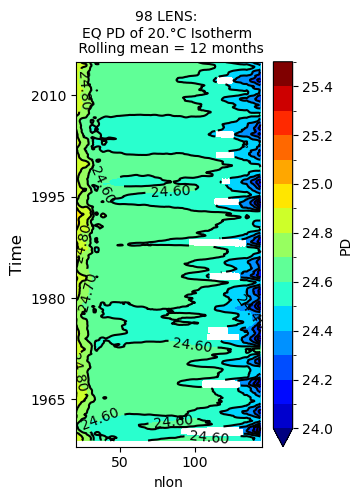

In [25]:
plt.figure(figsize=(3, 5))
cf = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contourf(cmap='jet', vmin=24., vmax=25.5, levels=16)
contour_obj = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contour(levels=np.arange(24., 25.5, 0.1), colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.title('98 LENS: \nEQ PD of 20°C Isotherm \n Rolling mean = 12 months', fontsize=10)
plt.ylabel('Time', fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(5, 3))
mean_114 = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').mean(dim='time')
std_114 = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').std(dim='time')
x_vals = mean_114[mean_114.dims[0]]
line_114 = mean_114.plot(yincrease=False)
plt.fill_between(x_vals, 
                mean_114 - std_114, 
                mean_114 + std_114, 
                alpha=0.3, color=line_114[0].get_color())
plt.title('98 LENS: PD of the 20°C isotherm at the EQ')
plt.ylabel('PD (g/cm3)', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('nlon', fontsize=12)
plt.grid(c='k', linestyle='dashed', alpha=0.2)
plt.ylim(25.4, 24.4)
plt.show()

In [28]:
regridded_climatology = regridded.groupby('time.month').mean(dim='time')

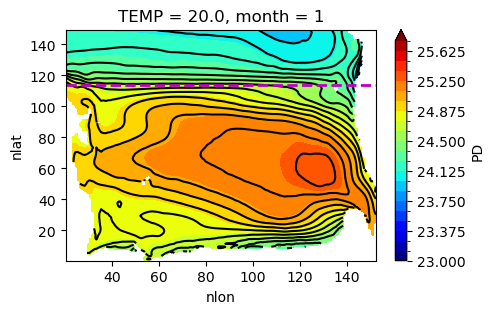

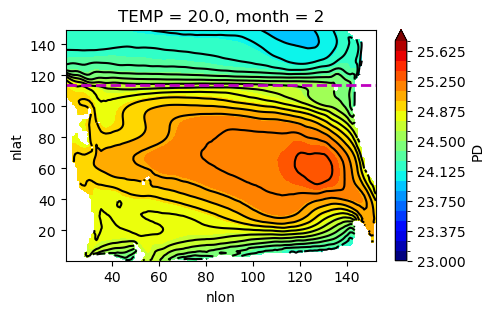

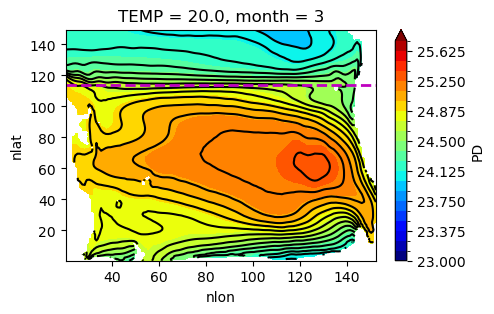

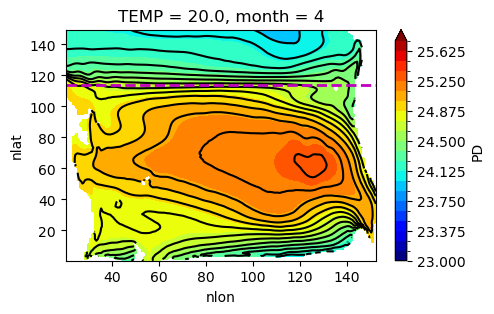

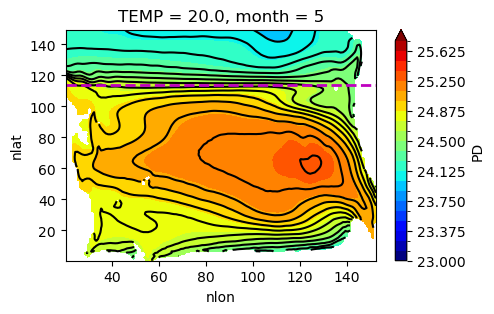

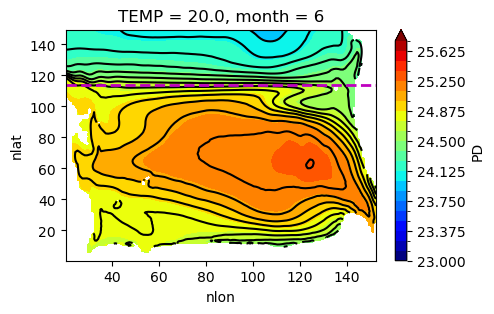

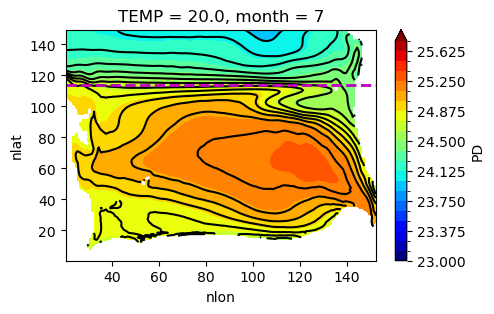

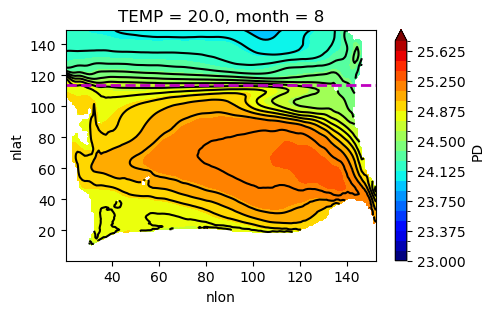

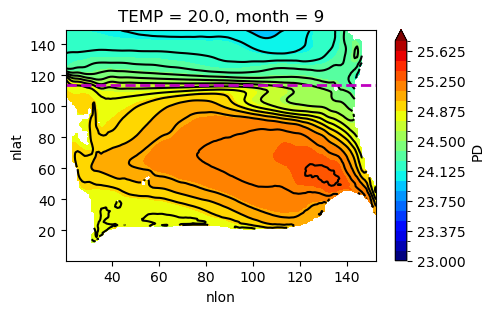

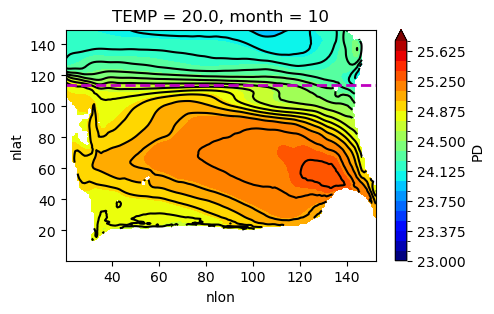

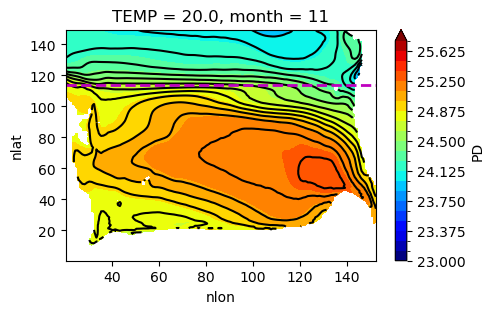

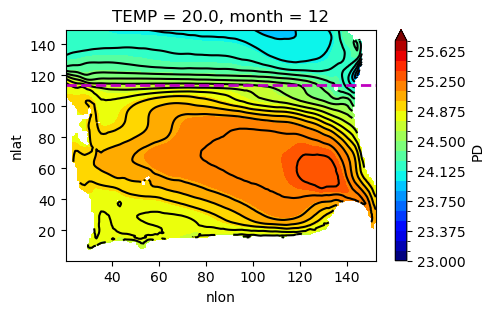

In [29]:
for month in range(12):
    plt.figure(figsize=(5, 3))
    regridded_climatology.isel(TEMP=2)[month,:150,20:].plot.contourf(vmin=23, 
                                                                     vmax=25.75, 
                                                                     levels=23, 
                                                                     cmap='jet')
    regridded_climatology.isel(TEMP=2)[month,:150,20:].plot.contour(
        levels=np.arange(23, 25.75, 0.1), cmap='k')
    plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
    plt.show()

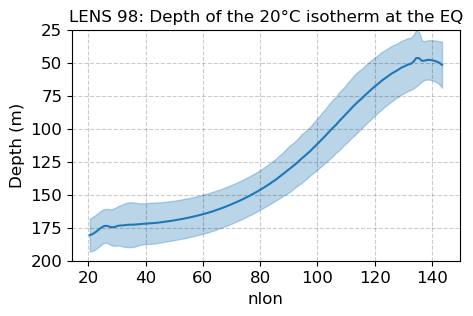

In [30]:
plt.figure(figsize=(5, 3))
mean_114 = (regridded_TEMP.z_t.isel(TEMP=2).mean(dim='time').isel(nlat_t=114)/100)[20:]
std_114 = (regridded_TEMP.z_t.isel(TEMP=2).std(dim='time').isel(nlat_t=114)/100)[20:]
x_vals = mean_114[mean_114.dims[0]]
line_114 = mean_114.plot(yincrease=False)
plt.fill_between(x_vals, 
                mean_114 - std_114, 
                mean_114 + std_114, 
                alpha=0.3, color=line_114[0].get_color())
plt.title('LENS 98: Depth of the 20°C isotherm at the EQ')
plt.ylabel('Depth (m)', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('nlon', fontsize=12)
plt.grid(c='k', linestyle='dashed', alpha=0.2)
plt.ylim(200, 25)
plt.show()

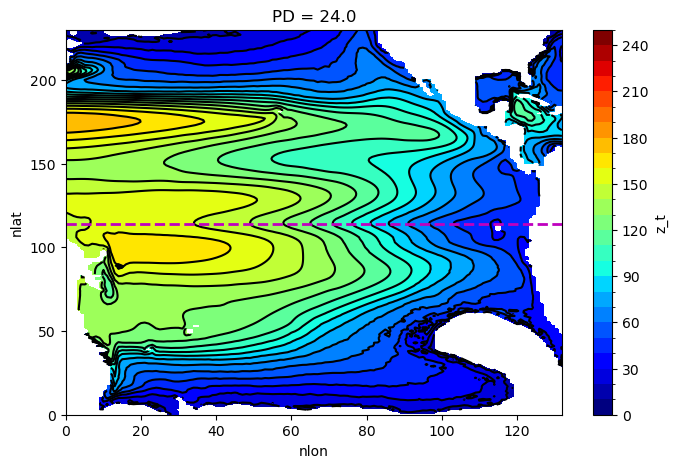

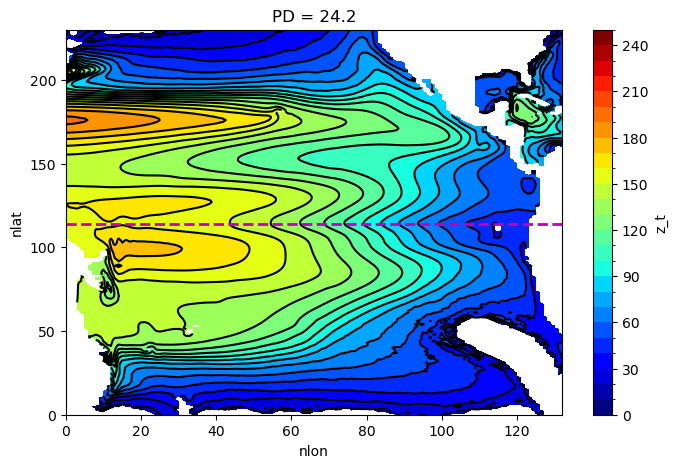

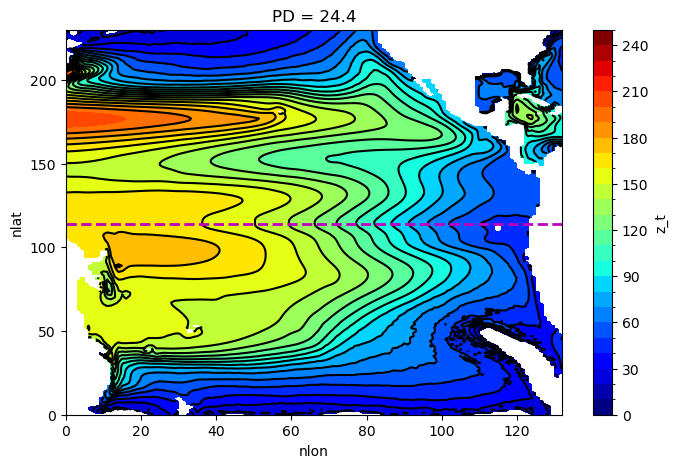

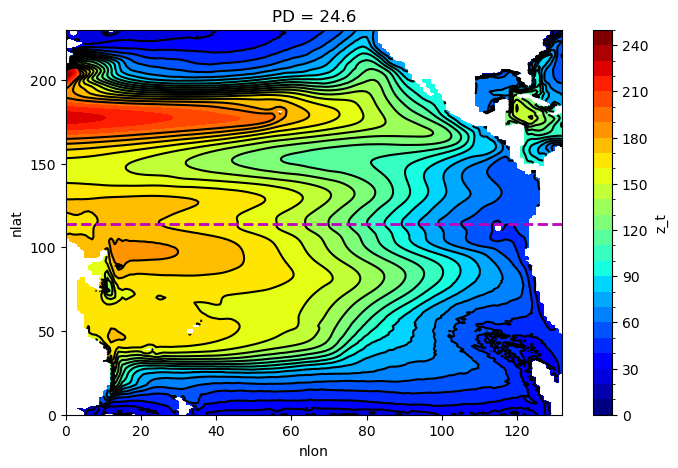

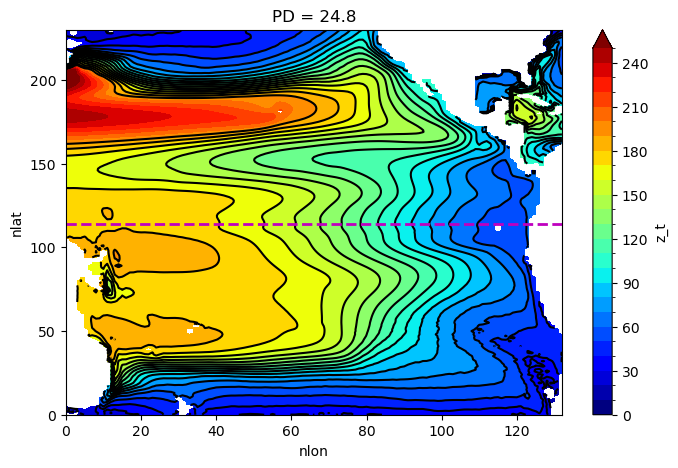

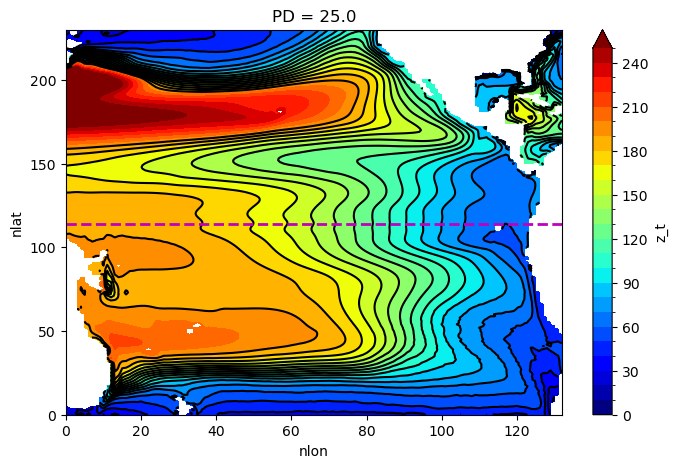

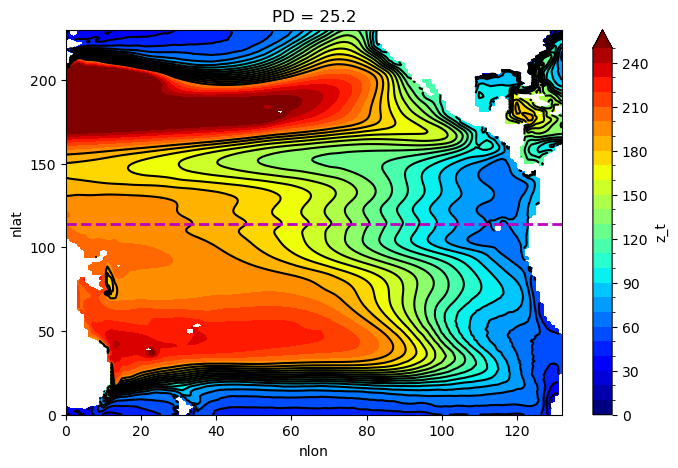

In [31]:
for i in range(7):
    plt.figure(figsize=(8, 5))
    (regridded_PD.z_t.isel(PD = i).mean(dim='time')/100)[:,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap='jet')
    (regridded_PD.z_t.isel(PD = i).mean(dim='time')/100)[:,20:].plot.contour(
        levels=np.arange(0, 200, 10), cmap='k')
    plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
    plt.show()

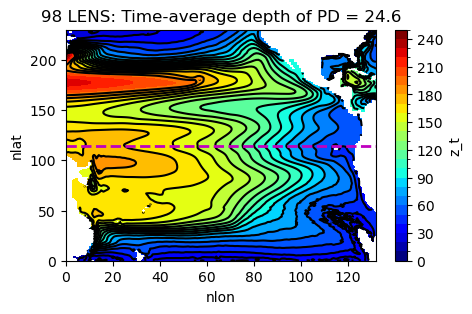

In [44]:
plt.figure(figsize=(5, 3))
(regridded_PD.z_t.isel(PD = 3).mean(dim='time')/100)[:,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap='jet')
(regridded_PD.z_t.isel(PD = 3).mean(dim='time')/100)[:,20:].plot.contour(
        levels=np.arange(0, 200, 10), cmap='k')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.title('98 LENS: Time-average depth of PD = 24.6')
plt.show()

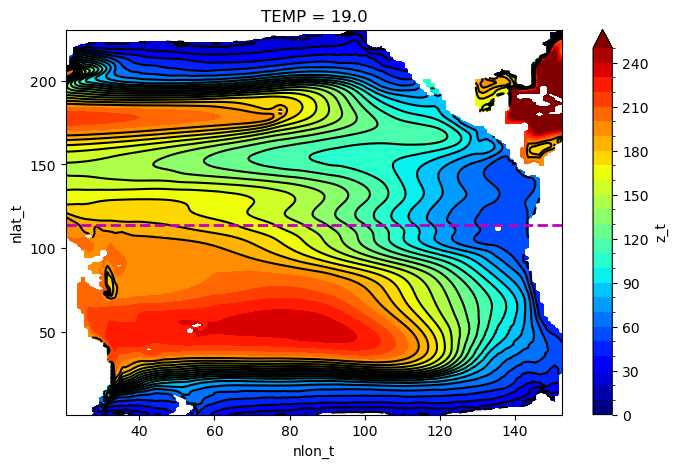

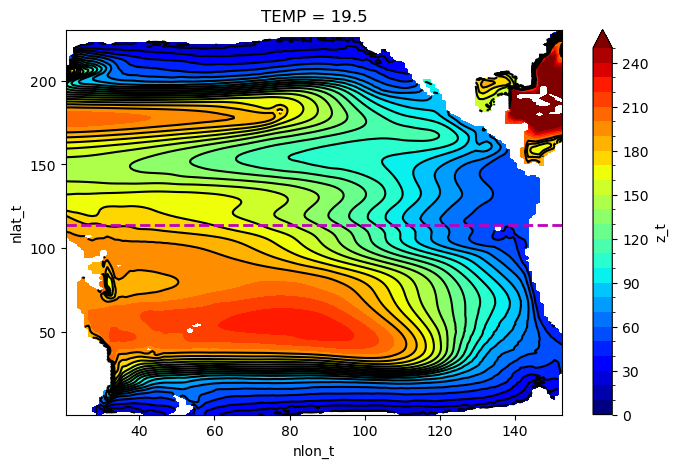

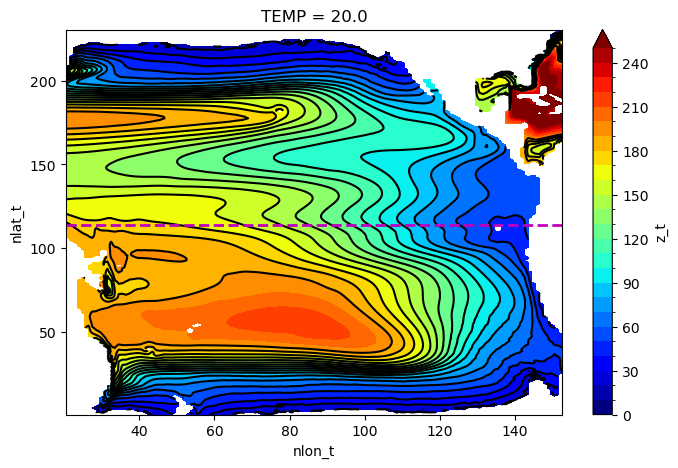

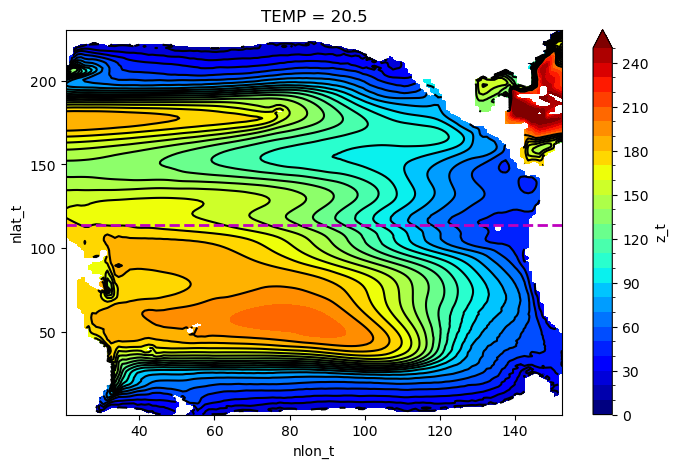

In [147]:
for i in range(4):
    plt.figure(figsize=(8, 5))
    (regridded_TEMP.z_t.isel(TEMP = i).mean(dim='time')/100)[:,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap='jet')
    (regridded_TEMP.z_t.isel(TEMP = i).mean(dim='time')/100)[:,20:].plot.contour(
        levels=np.arange(0, 200, 10), cmap='k')
    plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
    plt.show()

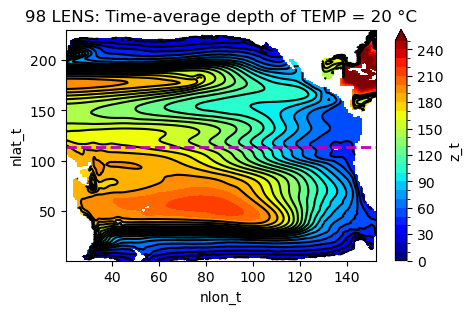

In [46]:
plt.figure(figsize=(5, 3))
(regridded_TEMP.z_t.isel(TEMP = 2).mean(dim='time')/100)[:,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap='jet')
(regridded_TEMP.z_t.isel(TEMP = 2).mean(dim='time')/100)[:,20:].plot.contour(
        levels=np.arange(0, 200, 10), cmap='k')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.title('98 LENS: Time-average depth of TEMP = 20 °C')
plt.show()

In [47]:
TEMP_zt = (regridded_TEMP.z_t.isel(TEMP = 2).mean(dim='time')/100)
PD_zt = (regridded_PD.z_t.isel(PD = 3).mean(dim='time')/100)

TEMP_zt = TEMP_zt.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})
zt_diff = PD_zt - TEMP_zt

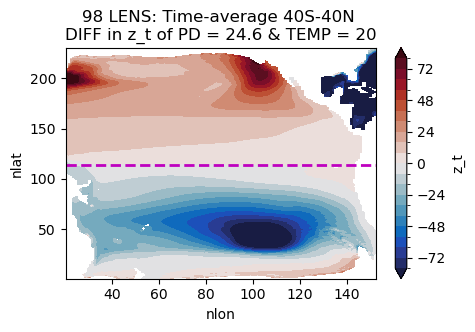

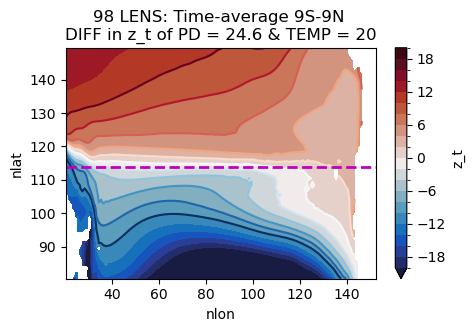

In [59]:
plt.figure(figsize=(5, 3))
zt_diff[:,20:].plot.contourf(vmin=-80, vmax=80, levels=21, cmap=cmocean.cm.balance)
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.title('98 LENS: Time-average 40S-40N \nDIFF in z_t of PD = 24.6 & TEMP = 20')
plt.show()

plt.figure(figsize=(5, 3))
zt_diff[80:150,20:].plot.contourf(vmin=-20, vmax=20, levels=21, cmap=cmocean.cm.balance)
zt_diff[80:150,20:].plot.contour(levels=np.arange(-10, 12, 2), cmap='RdBu_r')
plt.title('98 LENS: Time-average 9S-9N \nDIFF in z_t of PD = 24.6 & TEMP = 20')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.show()

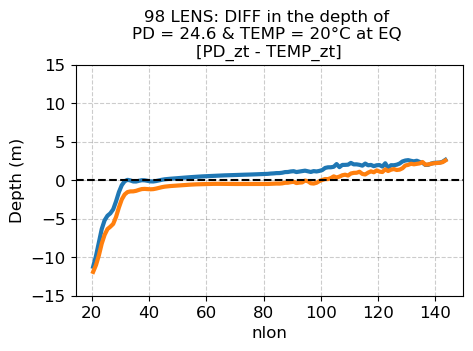

In [62]:
plt.figure(figsize=(5, 3))
zt_diff.isel(nlat = 115)[20:].plot(linewidth=3)
zt_diff.isel(nlat = 114)[20:].plot(linewidth=3)
plt.title('98 LENS: DIFF in the depth of \nPD = 24.6 & TEMP = 20°C at EQ \n[PD_zt - TEMP_zt]')
plt.ylabel('Depth (m)', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('nlon', fontsize=12)
plt.grid(c='k', linestyle='dashed', alpha=0.2)
plt.axhline(y=0, c='k', linestyle='dashed')
plt.ylim(-15, 15)
plt.show()

# FOSI

In [6]:
def interpolate_fosi_temp_salt_pd_onto_z_t():
    #### FOSI set up
    firstyear = 1959
    lastyear = 2020
    grid = pop_tools.get_grid('POP_gx1v7')
    mask = xr.where((grid['REGION_MASK']>0) & (grid['REGION_MASK']<9), 1, np.nan)
    fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
    fosi_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]
    
    field = 'PD'
    fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
    ds_smyle_fosi_PD = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,33))[:,:, 72:303,140:293].compute()
    ds_smyle_fosi_PD['time'] = fosi_montime_vals
    
    field = 'TEMP'
    fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
    ds_smyle_fosi_TEMP = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,33))[:,:, 72:303,140:293].compute()
    ds_smyle_fosi_TEMP['time'] = fosi_montime_vals
    
    # field = 'SALT'
    # fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
    # ds_smyle_fosi_SALT = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,33))[:,:, 72:303,140:293].compute()
    # ds_smyle_fosi_SALT['time'] = fosi_montime_vals

    variables_xr = xr.Dataset()
    variables_xr['PD'] = ds_smyle_fosi_PD*1000 - 1000
    variables_xr['TEMP'] = ds_smyle_fosi_TEMP
    # variables_xr['SALT'] = ds_smyle_fosi_SALT

    gridxgcm, dsxgcm = grid_info(variables_xr, ds_g_new)
    
    regridded_PD = regridded_var(dsxgcm, gridxgcm, 'PD',np.arange(23.5, 26.5, 0.5), 0)
    regridded_TEMP = regridded_var(dsxgcm, gridxgcm, 'TEMP',np.arange(19., 21., 0.5), 273.15)

    TEMP_zt = dsxgcm.TEMP.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})
    
    regridded = gridxgcm.transform(
            dsxgcm.PD - 0,
            axis="Z",
            target=np.arange(19,21,0.5),
            target_data=TEMP_zt,
            method="linear",)

    return regridded, regridded_PD, regridded_TEMP

In [7]:
regridded, regridded_PD, regridded_TEMP = interpolate_fosi_temp_salt_pd_onto_z_t()

In [8]:
regridded_PD.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_PD_FOSI.nc')
regridded_TEMP.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_TEMP_FOSI.nc')

In [11]:
regridded.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_PD_FOSI_other.nc')


In [11]:
#### FOSI set up
firstyear = 1959
lastyear = 2015
grid = pop_tools.get_grid('POP_gx1v7')
mask = xr.where((grid['REGION_MASK']>0) & (grid['REGION_MASK']<9), 1, np.nan)
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fosi_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]

field = 'PD'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
ds_smyle_fosi_PD = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,33))[:,:, 72:303,140:293].compute()
ds_smyle_fosi_PD['time'] = fosi_montime_vals

# field = 'PV'
# fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
# ds_smyle_fosi_PV = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,33))[:,:, 72:303,140:293].compute()
# ds_smyle_fosi_PV['time'] = fosi_montime_vals

field = 'TEMP'
fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
ds_smyle_fosi_TEMP = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,33))[:,:, 72:303,140:293].compute()
ds_smyle_fosi_TEMP['time'] = fosi_montime_vals

# field = 'SALT'
# fname = f'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.{field}.030601-036812.nc'
# ds_smyle_fosi_SALT = xr.open_dataset(fpath+fname)[field].isel(z_t = slice(0,33))[:,:, 72:303,140:293].compute()
# ds_smyle_fosi_SALT['time'] = fosi_montime_vals

KeyboardInterrupt: 

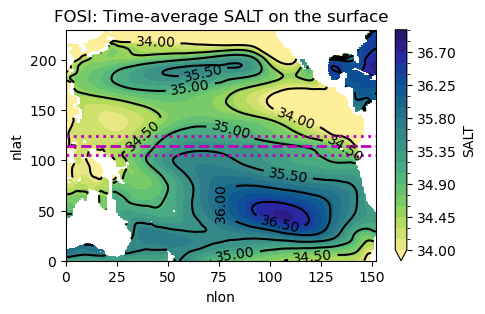

In [59]:
plt.figure(figsize=(5, 3))
cf = (ds_smyle_fosi_SALT.isel(z_t = 0).mean(dim='time')).plot.contourf(vmin=34, vmax=37, levels=21, cmap=cmocean.cm.haline_r)
contour_obj = (ds_smyle_fosi_SALT.isel(z_t = 0).mean(dim='time')).plot.contour(levels=np.arange(34, 37, 0.5), cmap='k')
# (ds_smyle_fosi_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[24.4, 24.6, 24.8], cmap='hotpink')
# (ds_smyle_fosi_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[25., 25.2, 25.4], cmap='cyan')

plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.title('FOSI: Time-average SALT on the surface')
plt.show()

In [ ]:
variables_xr = xr.Dataset()
variables_xr['PD'] = ds_smyle_fosi_PD*1000 - 1000
variables_xr['TEMP'] = ds_smyle_fosi_TEMP
variables_xr['PV'] = ds_smyle_fosi_PV
# variables_xr['SALT'] = ds_smyle_fosi_SALT

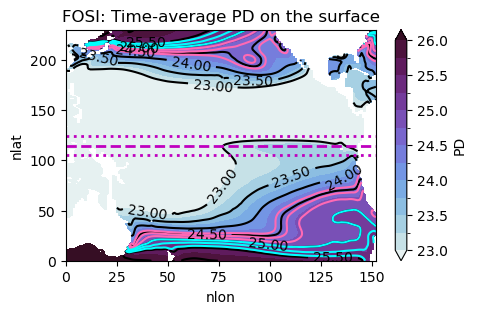

In [35]:
plt.figure(figsize=(5, 3))
cf = (ds_smyle_fosi_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contourf(vmin=23, vmax=26, levels=13, cmap=cmocean.cm.dense)
contour_obj = (ds_smyle_fosi_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[23, 23.5, 24, 24.5, 25, 25.5, 26], cmap='k')
(ds_smyle_fosi_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[24.4, 24.6, 24.8], cmap='hotpink')
(ds_smyle_fosi_PD.isel(z_t = 0).mean(dim='time')*1000-1000).plot.contour(levels=[25., 25.2, 25.4], cmap='cyan')

plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.title('FOSI: Time-average PD on the surface')
plt.show()

In [14]:
gridxgcm, dsxgcm = grid_info(variables_xr, ds_g_new)

# regridded_PD = regridded_var('PD',np.arange(24, 25.4, 0.2), 0)
regridded_TEMP = regridded_var('TEMP',np.arange(19., 21., 0.5), 273.15)

In [10]:
TEMP_zt = dsxgcm.TEMP.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})

regridded = gridxgcm.transform(
        dsxgcm.PD - 0,
        axis="Z",
        target=np.arange(19,21,0.5),
        target_data=TEMP_zt,
        method="linear",)

In [15]:
TEMP_zt = dsxgcm.TEMP.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})
PV_zt = dsxgcm.PV.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})
regridded_PV = gridxgcm.transform(
        PV_zt - 0,
        axis="Z",
        target=np.arange(19,21,0.5),
        target_data=TEMP_zt,
        method="linear",)

In [17]:
# regridded_PV.to_netcdf('/glade/derecho/scratch/cassiacai/regridded_PV_FOSI.nc')

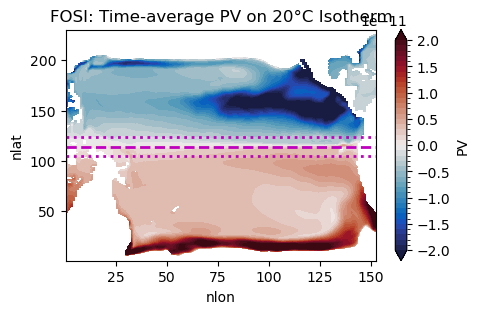

In [23]:
plt.figure(figsize=(5, 3))
cf = regridded_PV.isel(TEMP = 2)[0,:,:].plot.contourf(
    vmin=-2e-11, vmax=2e-11, levels=41, 
    cmap=cmocean.cm.balance)
# contour_obj = regridded_PV.isel(TEMP = 2).mean(dim='time')[:,:].plot.contour(colors='k')
# plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.title('FOSI: Time-average PV on 20°C Isotherm')
plt.show()

In [12]:
mask = xr.where(regridded.isel(TEMP = 2).mean(dim='time') > 25.55, np.nan, regridded.isel(TEMP = 2).mean(dim='time'))
mask_binarize = xr.where(mask > 0., 1., np.nan)

regridded_no_Atlantic = regridded*mask_binarize

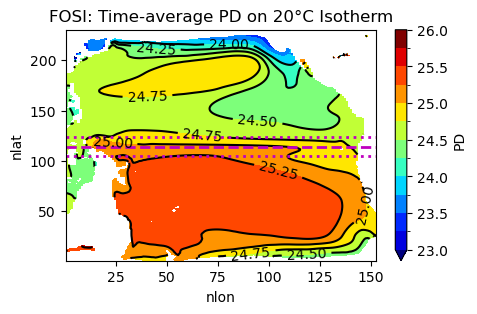

In [13]:
plt.figure(figsize=(5, 3))
cf = regridded_no_Atlantic.isel(TEMP = 2).mean(dim='time')[:,:].plot.contourf(vmin=23.0, vmax=26.0, levels=13, cmap='jet')
contour_obj = regridded_no_Atlantic.isel(TEMP = 2).mean(dim='time')[:,:].plot.contour(levels=[24.0, 24.25, 24.5, 24.75, 25., 25.25, 25.50], colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.axhline(y=105, c='m', linestyle='dotted', linewidth=2)
plt.axhline(y=124, c='m', linestyle='dotted', linewidth=2)
plt.title('FOSI: Time-average PD on 20°C Isotherm')
plt.show()

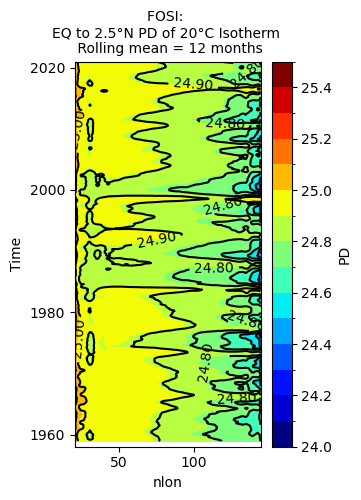

In [14]:
plt.figure(figsize=(3, 5))
cf = regridded.isel(TEMP = 2)[:,115:124,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contourf(cmap='jet', vmin=24., vmax=25.5, levels=16)
contour_obj = regridded.isel(TEMP = 2)[:,114:124,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contour(levels=np.arange(24., 25.5, 0.1), colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f', colors='k')
plt.title('FOSI: \nEQ to 2.5°N PD of 20°C Isotherm \n Rolling mean = 12 months', fontsize=10)
plt.ylabel('Time', fontsize=10)
plt.show()

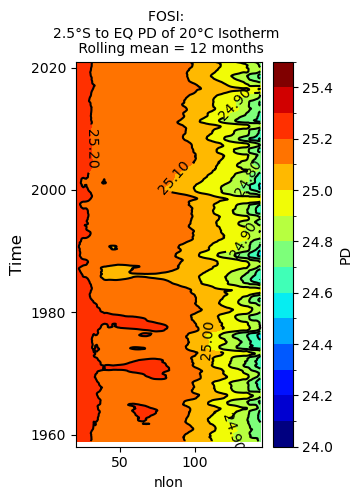

In [15]:
plt.figure(figsize=(3, 5))
cf = regridded.isel(TEMP = 2)[:,105:114,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contourf(cmap='jet', vmin=24., vmax=25.5, levels=16)
contour_obj = regridded.isel(TEMP = 2)[:,105:114,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contour(levels=np.arange(24., 25.5, 0.1), colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.title('FOSI: \n2.5°S to EQ PD of 20°C Isotherm \n Rolling mean = 12 months', fontsize=10)
plt.ylabel('Time', fontsize=12)
plt.show()

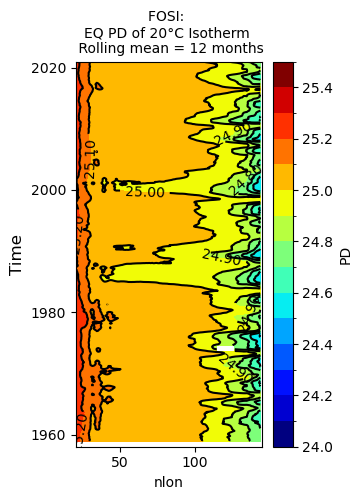

In [17]:
plt.figure(figsize=(3, 5))
cf = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contourf(cmap='jet', vmin=24., vmax=25.5, levels=16)
contour_obj = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').rolling(time=12).mean().plot.contour(levels=np.arange(24., 25.5, 0.1), colors='k')
plt.clabel(contour_obj, inline=True, fontsize=10, fmt='%.2f')
plt.title('FOSI: \nEQ PD of 20°C Isotherm \n Rolling mean = 12 months', fontsize=10)
plt.ylabel('Time', fontsize=12)
plt.show()

In [18]:
regridded_climatology = regridded.groupby('time.month').mean(dim='time')

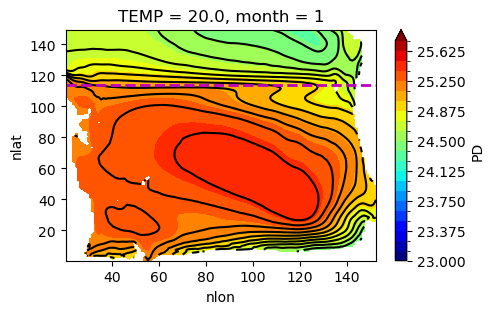

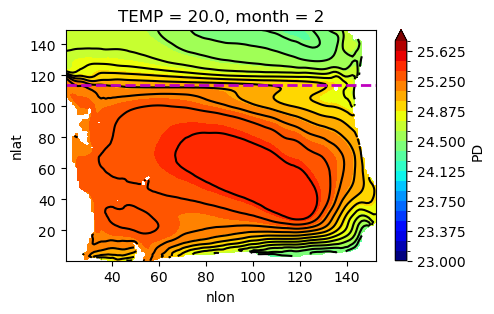

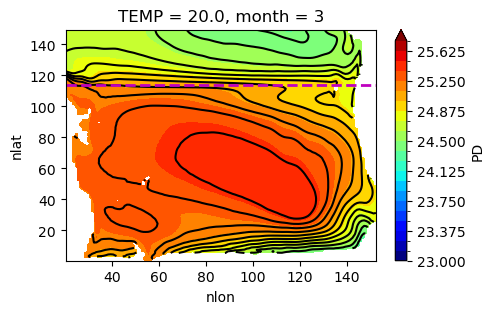

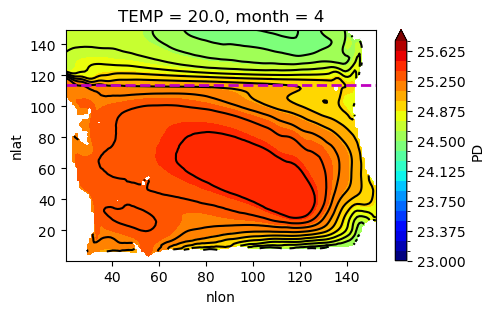

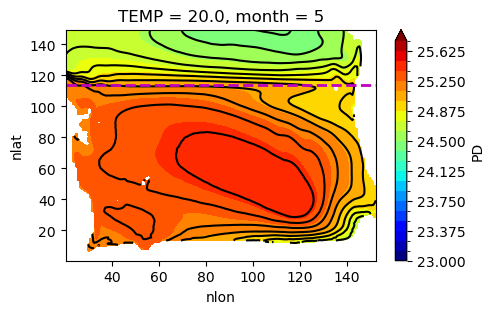

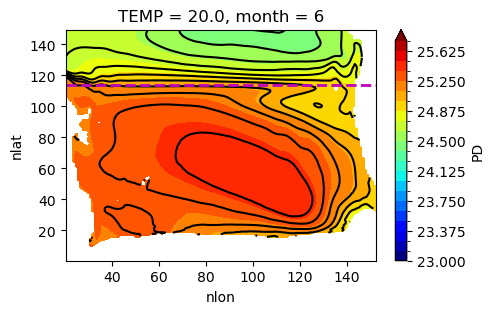

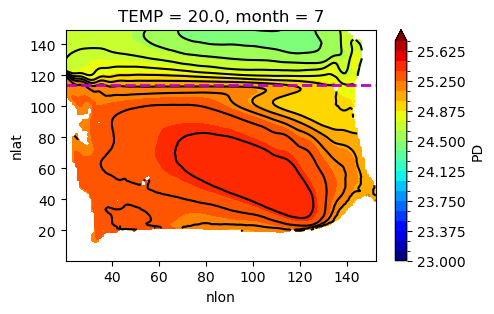

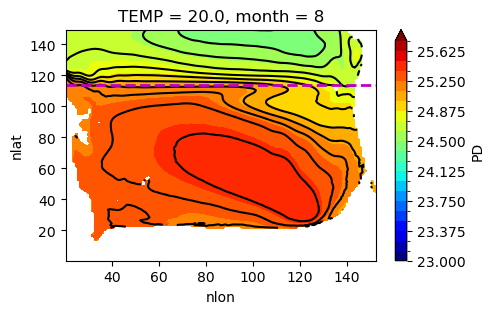

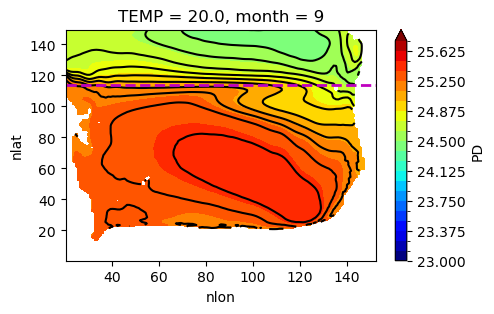

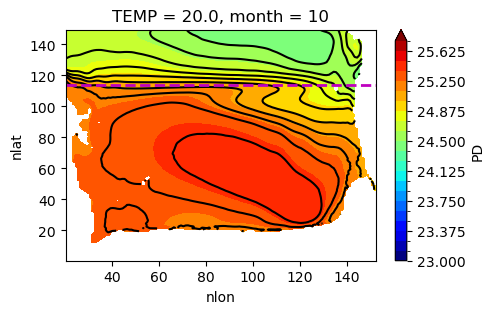

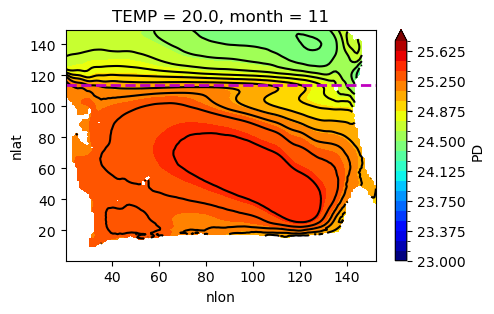

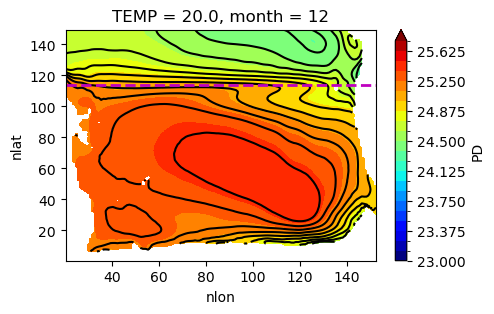

In [19]:
for month in range(12):
    plt.figure(figsize=(5, 3))
    regridded_climatology.isel(TEMP=2)[month,:150,20:].plot.contourf(vmin=23, 
                                                                     vmax=25.75, 
                                                                     levels=23, 
                                                                     cmap='jet')
    regridded_climatology.isel(TEMP=2)[month,:150,20:].plot.contour(
        levels=np.arange(23, 25.75, 0.1), cmap='k')
    plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
    plt.show()

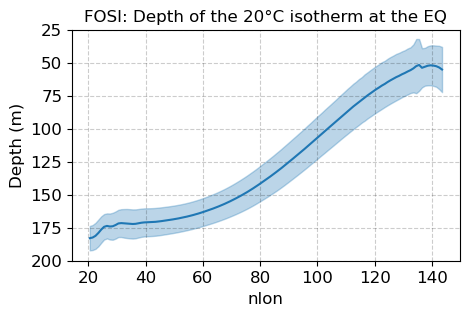

In [21]:
plt.figure(figsize=(5, 3))
mean_114 = (regridded_TEMP.z_t.isel(TEMP=2).mean(dim='time').isel(nlat_t=114)/100)[20:]
std_114 = (regridded_TEMP.z_t.isel(TEMP=2).std(dim='time').isel(nlat_t=114)/100)[20:]
x_vals = mean_114[mean_114.dims[0]]
line_114 = mean_114.plot(yincrease=False)
plt.fill_between(x_vals, 
                mean_114 - std_114, 
                mean_114 + std_114, 
                alpha=0.3, color=line_114[0].get_color())
plt.title('FOSI: Depth of the 20°C isotherm at the EQ')
plt.ylabel('Depth (m)', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('nlon', fontsize=12)
plt.grid(c='k', linestyle='dashed', alpha=0.2)
plt.ylim(200, 25)
plt.show()

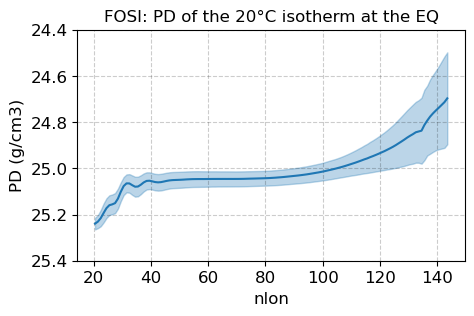

In [24]:
plt.figure(figsize=(5, 3))
mean_114 = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').mean(dim='time')
std_114 = regridded.isel(TEMP = 2)[:,114:115,20:145].mean(dim='nlat').std(dim='time')
x_vals = mean_114[mean_114.dims[0]]
line_114 = mean_114.plot(yincrease=False)
plt.fill_between(x_vals, 
                mean_114 - std_114, 
                mean_114 + std_114, 
                alpha=0.3, color=line_114[0].get_color())
plt.title('FOSI: PD of the 20°C isotherm at the EQ')
plt.ylabel('PD (g/cm3)', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('nlon', fontsize=12)
plt.grid(c='k', linestyle='dashed', alpha=0.2)
plt.ylim(25.4, 24.4)
plt.show()

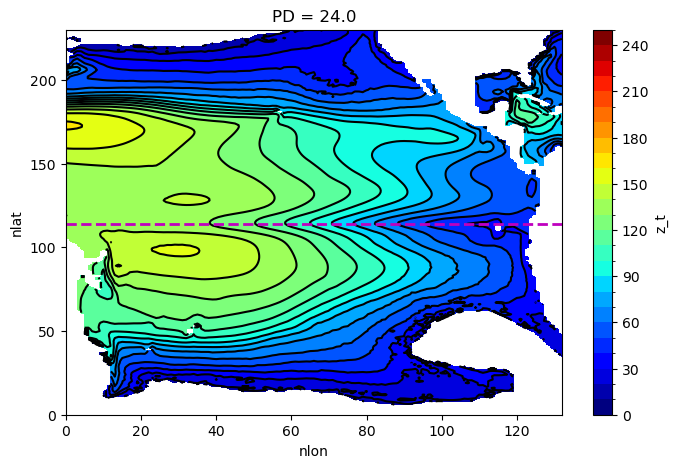

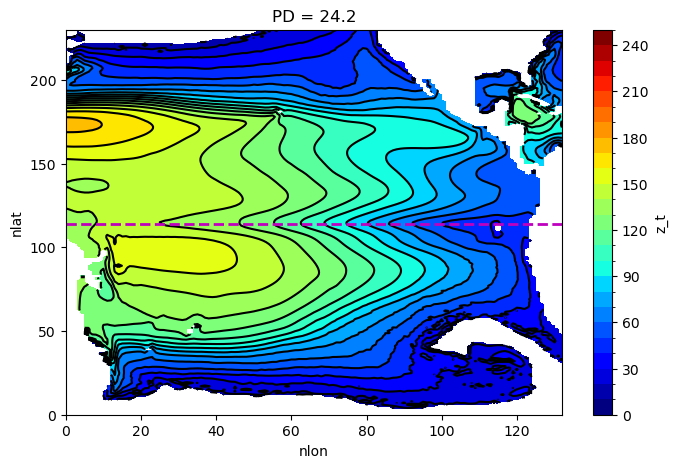

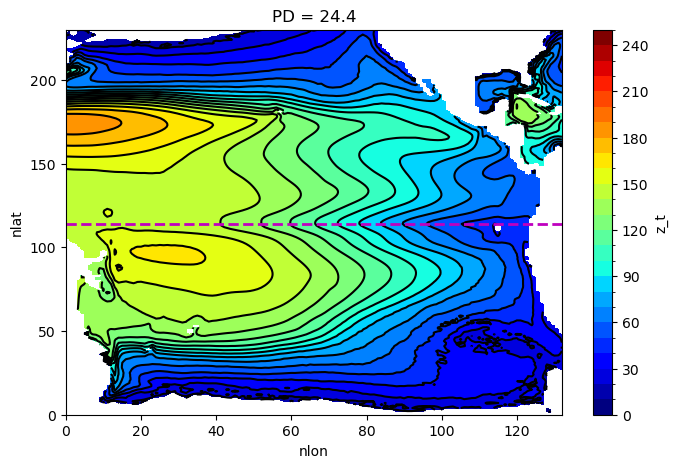

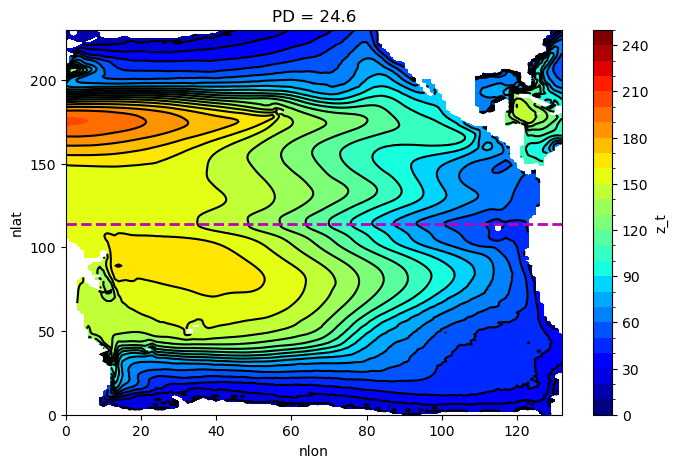

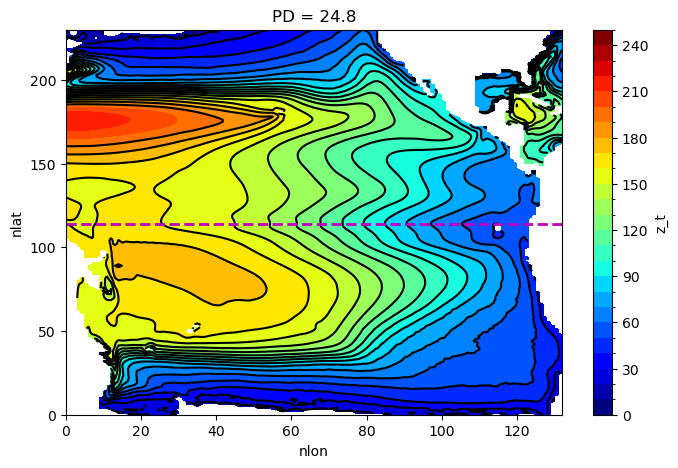

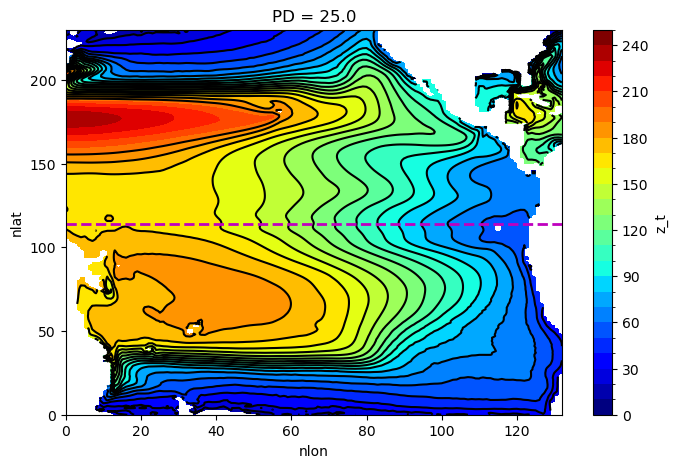

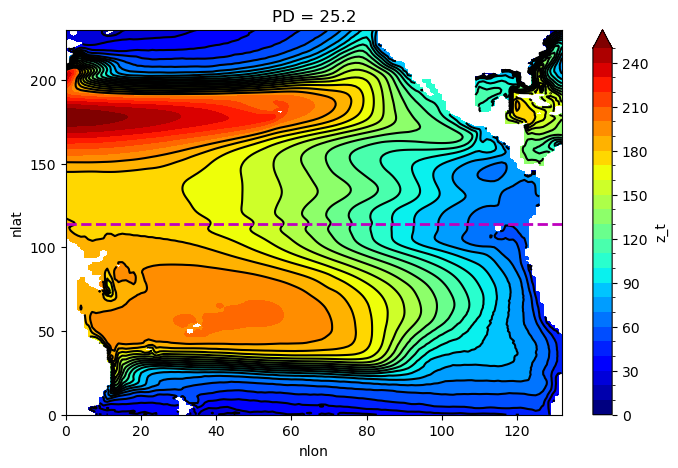

In [25]:
for i in range(7):
    plt.figure(figsize=(8, 5))
    (regridded_PD.z_t.isel(PD = i).mean(dim='time')/100)[:,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap='jet')
    (regridded_PD.z_t.isel(PD = i).mean(dim='time')/100)[:,20:].plot.contour(
        levels=np.arange(0, 200, 10), cmap='k')
    plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
    plt.show()

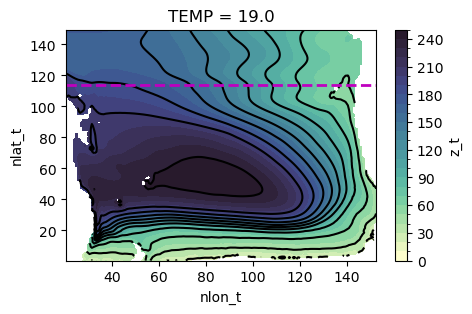

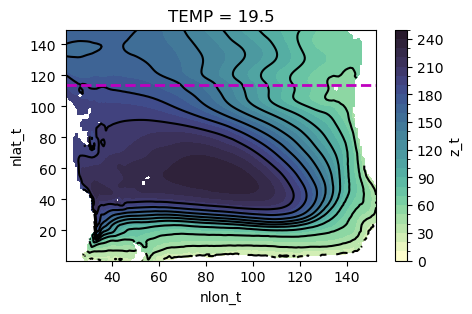

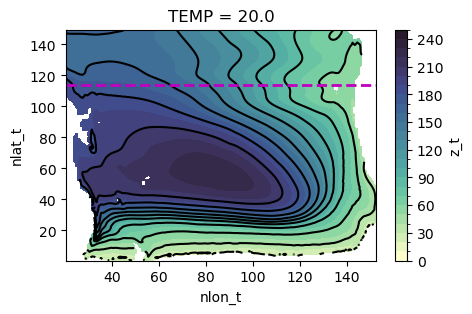

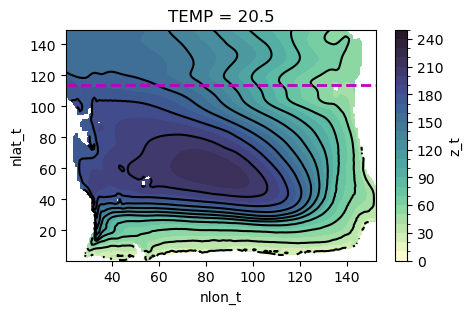

In [26]:
for i in range(4):
    plt.figure(figsize=(5, 3))
    (regridded_TEMP.z_t.isel(TEMP = i).mean(dim='time')/100)[:150,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap=cmocean.cm.deep)
    (regridded_TEMP.z_t.isel(TEMP = i).mean(dim='time')/100)[:150,20:].plot.contour(
        levels=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 240], cmap='k')
    plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
    plt.show()

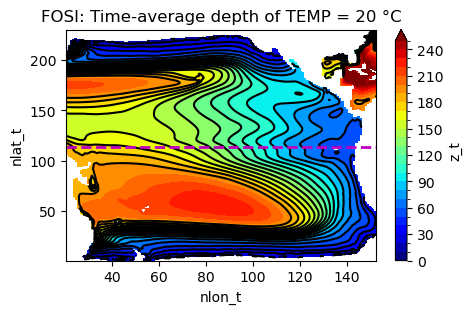

In [28]:
plt.figure(figsize=(5, 3))
(regridded_TEMP.z_t.isel(TEMP = 2).mean(dim='time')/100)[:,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap='jet')
(regridded_TEMP.z_t.isel(TEMP = 2).mean(dim='time')/100)[:,20:].plot.contour(
        levels=np.arange(0, 200, 10), cmap='k')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.title('FOSI: Time-average depth of TEMP = 20 °C')
plt.show()

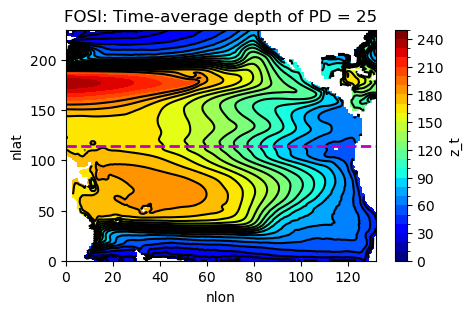

In [44]:
plt.figure(figsize=(5, 3))
(regridded_PD.z_t.isel(PD = 5).mean(dim='time')/100)[:,20:].plot.contourf(
        vmin=0, vmax=250, levels=26, cmap='jet')
(regridded_PD.z_t.isel(PD = 5).mean(dim='time')/100)[:,20:].plot.contour(
        levels=np.arange(0, 200, 10), cmap='k')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.title('FOSI: Time-average depth of PD = 25')
plt.show()

In [45]:
TEMP_zt = (regridded_TEMP.z_t.isel(TEMP = 2).mean(dim='time')/100)
PD_zt = (regridded_PD.z_t.isel(PD = 5).mean(dim='time')/100)

TEMP_zt = TEMP_zt.rename({'nlat_t': 'nlat', 'nlon_t': 'nlon'})
zt_diff = PD_zt - TEMP_zt

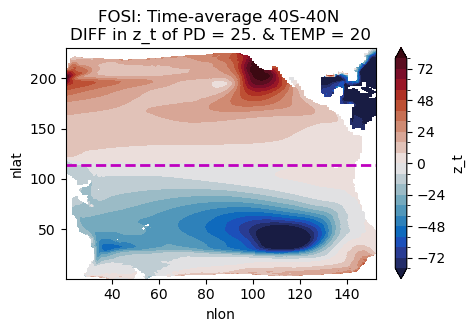

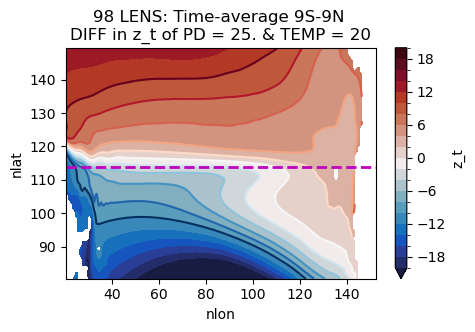

In [46]:
plt.figure(figsize=(5, 3))
zt_diff[:,20:].plot.contourf(vmin=-80, vmax=80, levels=21, cmap=cmocean.cm.balance)
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.title('FOSI: Time-average 40S-40N \nDIFF in z_t of PD = 25. & TEMP = 20')
plt.show()

plt.figure(figsize=(5, 3))
zt_diff[80:150,20:].plot.contourf(vmin=-20, vmax=20, levels=21, cmap=cmocean.cm.balance)
zt_diff[80:150,20:].plot.contour(levels=np.arange(-10, 12, 2), cmap='RdBu_r')
plt.title('98 LENS: Time-average 9S-9N \nDIFF in z_t of PD = 25. & TEMP = 20')
plt.axhline(y=114, c='m', linestyle='dashed', linewidth=2)
plt.show()

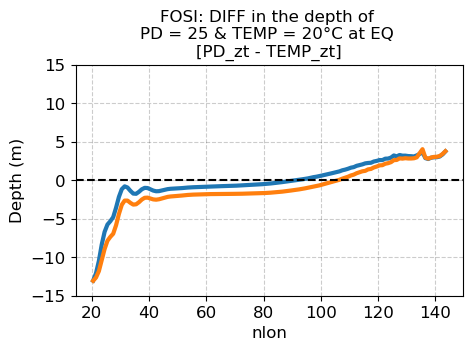

In [49]:
plt.figure(figsize=(5, 3))
zt_diff.isel(nlat = 115)[20:].plot(linewidth=3)
zt_diff.isel(nlat = 114)[20:].plot(linewidth=3)
plt.title('FOSI: DIFF in the depth of \nPD = 25 & TEMP = 20°C at EQ \n[PD_zt - TEMP_zt]')
plt.ylabel('Depth (m)', fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('nlon', fontsize=12)
plt.grid(c='k', linestyle='dashed', alpha=0.2)
plt.axhline(y=0, c='k', linestyle='dashed')
plt.ylim(-15, 15)
plt.show()

# Scratch

In [10]:
# Scratch
# GRID
DZT = np.zeros((33,231,153))

for k in range(33):
    DZT[k,:,:] = variables_xr.z_t[k]
    
ds2 = xr.Dataset({'DZT': (['z_t','nlat','nlon',], DZT),
                       'DZU': (['z_t','nlat','nlon'], DZT)},
                        coords={'TLAT': (['nlat','nlon'],variables_xr.TLAT.data),
                                'TLONG': (['nlat','nlon'],variables_xr.TLONG.data),
                                'ULAT': (['nlat','nlon'],variables_xr.ULAT.data),
                                'ULONG': (['nlat','nlon'],variables_xr.ULONG.data),
                                'z_t': (['z_t'],variables_xr.z_t.data)})
variables_xr = variables_xr.assign_coords(z_w=ds_g_new.z_w[:33])
variables_xr = variables_xr.assign_coords(z_w_bot=ds_g_new.z_w_bot[:33])

variables_xr["DXU"] = ds_g_new.DXU
variables_xr["DYU"] = ds_g_new.DYU
variables_xr["DXT"] = ds_g_new.DXT
variables_xr["DYT"] = ds_g_new.DYT
variables_xr["UAREA"] = ds_g_new.UAREA
variables_xr["TAREA"] = ds_g_new.TAREA
variables_xr["DZT"] = ds2.DZT
variables_xr["DZU"] = ds2.DZU
variables_xr["dz"] = variables_xr.z_t

variables_xr.DZT.attrs["long_name"] = "Thickness of T cells"
variables_xr.DZT.attrs["units"] = "centimeter"
variables_xr.DZT.attrs["grid_loc"] = "3111"
variables_xr.DZU.attrs["long_name"] = "Thickness of U cells"
variables_xr.DZU.attrs["units"] = "centimeter"
variables_xr.DZU.attrs["grid_loc"] = "3221"

metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    variables_xr,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)

dsxgcm["rho"] = pop_tools.eos(dsxgcm.SALT, dsxgcm.TEMP, depth=dsxgcm.z_t * 1e-2)

regridded = gridxgcm.transform(
    dsxgcm['PD'],
    axis="Z",
    target=np.arange(23.5, 25.5, 0.5),
    target_data=dsxgcm['PD'],
    method="linear",
)

regridded.coords["z_t"] = gridxgcm.transform(
    dsxgcm.z_t.broadcast_like(dsxgcm.PD),
    axis="Z",
    target=np.arange(23.5, 25.5, 0.5),
    target_data=dsxgcm.PD,
    method="linear",
)

regridded = gridxgcm.transform(
    dsxgcm.TEMP -273.15,
    axis="Z",
    target=np.arange(19, 23.5, 0.5),
    target_data=dsxgcm.TEMP,
    method="linear",
)

regridded.coords["z_t"] = gridxgcm.transform(
    dsxgcm.z_t.broadcast_like(dsxgcm.TEMP),
    axis="Z",
    target=np.arange(19,25,0.5),
    target_data=dsxgcm.TEMP,
    method="linear",
)